# Kinematics

In [21]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import numpy as np
from math import cos, sin, pi, atan2, sqrt, acos
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import rc
from IPython.display import HTML

In [2]:
from quadruped import DiscreteRippleGait
from quadruped import Leg4

In [3]:
# when i call the animation, this will make it work
rc('animation', html='html5')

# Walking

In [178]:
# using gait, lets create the leg angles
# gait: cmd -> feet position for each step
# leg: feet pos -> servo angles for each step
# rplot -> plots each of those servo angles

data = {
    # [ length, (limits), offset]
    'coxa':   [52, [-90, 90], 150],
    'femur':  [90, [-100, 100], 150],   # fixme
    'tibia':  [89, [-190, 120], 220],  # fixme
    'tarsus': [90, [-90, 90], 150],

    # gait
    # Angles: 0.00 75.60 -120.39 -45.22
    # 0.00 93.51 -138.68 -44.83
    'stand': [0, 94, -139, -45],  # this determines the neutral leg position
    # 'sit': [0, 90, -90, -90],

    # engine
    # 'serialPort': '/dev/tty.usbserial-A506BOT5'
}

leg = Leg4(data)  # 4 servo leg
gait = DiscreteRippleGait(35.0, leg.getNeutralPos())  # ripple gait

# cmd = [1,0,0]                             # go straight
cmd = [0,0,pi/2]                             # turn
pts = gait.oneCycle_alt(*cmd)              # array of 3d foot pts
# print(pts)
angle = leg.generateServoAngles_alt(pts)  # array of leg servo angles
# print(angle)

DH2Servo[1] error 104 > 100
DH2Servo[1] error 109 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 109 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 109 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 104 > 100
DH2Servo[1] error 109 > 100
DH2Servo[1] error 104 > 100


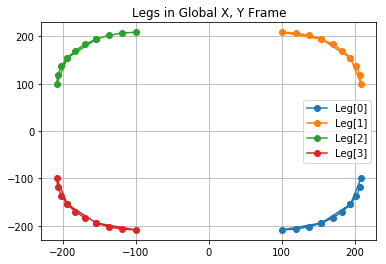

In [179]:
def rot_z(t, c):
    """
    t - theta [radians]
    c - [x,y,z]
    return - [x,y,z] numpy array rotated about z-axis
    """
    ans = [
        c[0]*cos(t)-c[1]*sin(t),
        c[0]*sin(t)+c[1]*cos(t),
        c[2]
    ]

    return ans

# plot things in global body frame
# body = [(-100,100), (-100,-100),(100,-100),(100,100)] # CCW
body = [(100,-100), (100,100),(-100,100),(-100,-100)] # CCW
frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]
for ll in range(4):
    aa = frame[ll]
    pp = [rot_z(aa, p) for p in pts[ll]]
    xx = [v[0]+body[ll][0] for v in pp]
    yy = [v[1]+body[ll][1] for v in pp]
    plt.title('Legs in Global X, Y Frame'.format(ll))
    plt.plot(xx,yy, label='Leg[{}]'.format(ll), marker='o')
    plt.grid(True)
plt.legend();

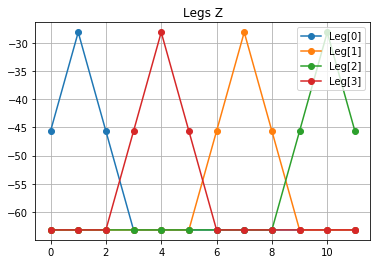

In [182]:
# order of lift is: 0, 3, 1, 2, repeat
for ll in range(4):
    ww = [sqrt(v[0]**2 + v[1]**2) for v in pts[ll]]
    zz = [v[2] for v in pts[ll]]
    plt.title('Legs Z'.format(ll))
    plt.plot(zz, label='Leg[{}]'.format(ll), marker='o')
    plt.grid(True)
plt.legend();

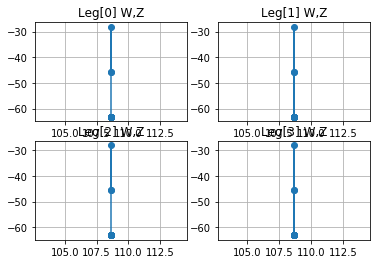

In [184]:
for ll in range(4):
    ww = [sqrt(v[0]**2 + v[1]**2) for v in pts[ll]]
    zz = [v[2] for v in pts[ll]]
    plt.subplot(2,2,ll+1)
    plt.plot(ww,zz, marker='o')
    plt.title('Leg[{}] W,Z'.format(ll))
    plt.grid()

In [143]:
# plt.plot(angle[0])
# plt.ylabel('Angle [deg]')
# plt.xlabel('Step')
# plt.grid();

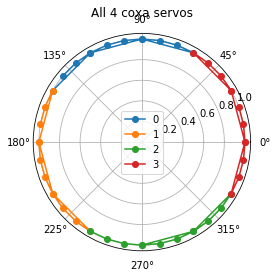

In [185]:
ax = plt.subplot(111, projection='polar')
for ll in range(4):
    tt = [(v[0]*pi/180)+frame[ll] for v in angle[ll]]
    rr = [1]*len(tt)
    ax.plot(tt, rr, label=str(ll), marker='o')
ax.legend()
ax.set_title('All 4 coxa servos');

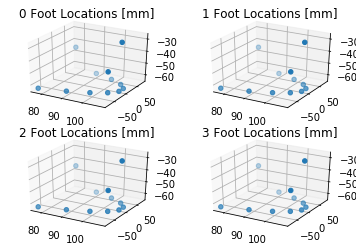

In [187]:
fig = plt.figure()
for ll in range(4):
    ax = fig.add_subplot(2,2,ll+1, projection='3d')
    xx = [v[0] for v in pts[ll]]
    yy = [v[1] for v in pts[ll]]
    zz = [v[2] for v in pts[ll]]
    ax.scatter(xx,yy,zz)
    ax.set_title('{} Foot Locations [mm]'.format(ll));

# Animation

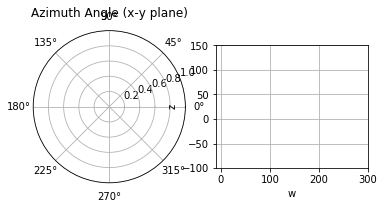

In [188]:
fig = plt.figure()

# radial plot 
ax1 = fig.add_subplot(121,projection='polar')
ax1.set_title('Azimuth Angle (x-y plane)')
# line1, = ax1.plot([], [], lw=2)
line1 = Line2D([], [], color='black')
ax1.add_line(line1)
# ax1.set_aspect('equal', 'datalim')

# scatter plot
ax2 = fig.add_subplot(122, aspect='equal')
# line2, = ax2.plot([], [], lw=2)
line2 = Line2D([], [], color='black', linewidth=2)
ax2.set_xlabel('w')
ax2.set_ylabel('z')
ax2.add_line(line2)
ax2.set_xlim(-10, 300)
ax2.set_ylim(-100, 150)
# ax2.set_aspect('equal')
ax2.grid()  # turn grid on


def rplot(t1, t2, t3, t4, degrees=True):
    """Given the 4 joint angles (in rads), plot the arm in the x-y and w-z planes

    x = (d2 + l1*cos(t2) + l2*cos(t2 + t3) + l3*cos(t2 + t3 + t4))*cos(t1)
    y = (d2 + l1*cos(t2) + l2*cos(t2 + t3) + l3*cos(t2 + t3 + t4))*sin(t1)
    z = l1*sin(t2) + l2*sin(t2 + t3) + l3*sin(t2 + t3 + t4)
    """
    l1 = 52
    l2 = 89
    l3 = 90
    l4 = 95

    ptsx = [0]
    ptsy = [0]

    if degrees:
        t1 *= pi/180
        t2 *= pi/180
        t3 *= pi/180
        t4 *= pi/180


    # our definition is reverse or these joints
    # link 1
    x0 = l1
    y0 = 0
    ptsx.append(x0)
    ptsy.append(y0)

    # link 2
    x1 = x0 + l2*cos(t2)
    y1 = y0 + l2*sin(t2)
    ptsx.append(x1)
    ptsy.append(y1)

    # link 3
    x2 = x1 + l3*cos(t2 + t3)
    y2 = y1 + l3*sin(t2 + t3)
    ptsx.append(x2)
    ptsy.append(y2)

    # link 4
    x3 = x2 + l4*cos(t2 + t3 + t4)
    y3 = y2 + l4*sin(t2 + t3 + t4)
    ptsx.append(x3)
    ptsy.append(y3)

    line1.set_data([0, t1], [0, 1.0])
    line2.set_data(ptsx, ptsy)
    return (line1, line2)

def animate(framedata):
    i = framedata
    angles = angle[0][i]
    # put back into DH space, note, the offsets aren't all the same
    aa = [a-o for a,o in zip(angles, [150,150,220,150])]
    return rplot(*aa)

In [189]:
# interval: time between frames in msec, default is 200
# frames: how many frames will be made for the movie loop
ani = animation.FuncAnimation(fig, animate, frames=len(angle[0]), interval=200, blit=True)
ani

In [ ]:
# HTML(ani.to_html5_video())

In [ ]:
# anim.save('mymovie.mp4')

# Double Check Forward/Inverse Kinematics

In [19]:
n = leg.getNeutralPos()
print(n)

(107.44440468551944, 0.0, -60.571515030318324)


In [20]:
# 'stand': [0, 75, -120, -65]
n = leg.forward(0, 75, -120, -65)  # angles in
print('foot loc', n)
a = leg.inverse(*n)
print('servo angles', a)  # these should match the angles in

foot loc (107.44440468551944, 0.0, -60.571515030318324)
servo angles (0.0, 96.57730528840247, -138.94788235573154, -47.629422932670934)


In [79]:
len(angle[0])

12

In [80]:
leg.forward(8.243324668836351, 103.68176102227886, -76.593875312737, -47.087885709541894)

(192.51246371438216, 27.89007871277556, 97.19113294229405)

In [81]:
leg.inverse(110.61860639192741, 1.9641855032959654, -63.15173900221855)

(1.017258469790174, 92.65808989232781, -137.76963663027558, -44.88845326205218)

In [176]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the  appearance. Line properties and *fmt* can be mixed.
    The following two calls yield identical resu

In [139]:
# not all of the offsets are the same ... 
# def error(aa, pp):
#     def err(a, b):
#         return sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)
#     erra=[]
#     errp = []
#     for a,p in zip(aa,pp):
#         p2 = leg.forward(*a)
#         a2 = leg.inverse(*p)
#         erra.append(err(a,a2))
#         errp.append(err(p,p2))
        
#     plt.subplot(1,2,1)
#     plt.plot(erra)
#     plt.title('Forward A')
    
#     plt.subplot(1,2,2)
#     plt.plot(errp)
#     plt.title('Inverse P')

# error(angle[0], pts[0])
    
# print(pi/4*180/pi)
# print(3*pi/4*180/pi)
# print(360-pi/4*180/pi)
# print(360-3*pi/4*180/pi)